# Imports

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Utils

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)
    else:
        plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [5]:
def trend(time, slope=0):
    return slope * time

In [11]:
def seasonal_pattern(season_time):
    data_pattern = np.where(season_time <0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))
    return data_pattern

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

In [9]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise

# Generate the synthetic data

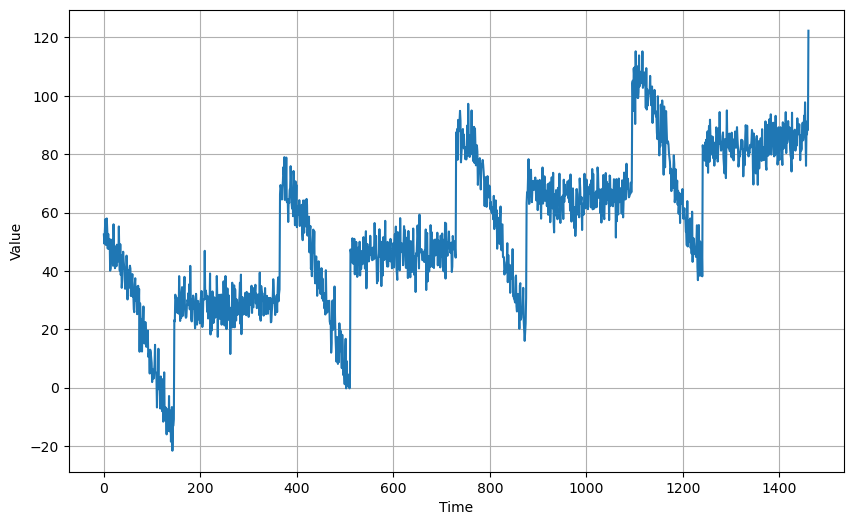

In [19]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

plot_series(time, series)

# Split the dataset

In [20]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare features and labels

In [24]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)

    return dataset

In [46]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [47]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20, 1)
shape of label: (32, 1)


2025-03-31 17:03:35.240356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Build the model

In [34]:
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

# Tune the learning rate

In [36]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.7290 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.1868 - learning_rate: 1.1220e-08
Epoch 3/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.7893

2025-03-31 16:52:50.157622: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/pndx/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.3200 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.5489 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.9494 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.5860 - learning_rate: 1.7783e-08
Epoch 7/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.9445

2025-03-31 16:52:50.758996: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.5734 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.7872 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.0856 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.4434 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.8350 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.2372 - learning_rate: 3.5481e-08
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6478 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0729 - learning_rate: 4.4668e-08
Epoch 15/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.3762

2025-03-31 16:52:51.961403: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5261 - learning_rate: 5.0119e-08
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.0080 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.4993 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9860 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.4581 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.9104 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.3421 - learning_rate: 1.0000e-07
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.7495 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.1376 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.5179 - learning_rate: 1.4125e-07
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

2025-03-31 16:52:54.290995: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4977 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0871 - learning_rate: 3.5481e-07
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6940 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3769 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1434 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9795 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8607 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7618 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6423 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5100 - learning_rate: 8.9125e-07
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3

2025-03-31 16:52:59.081648: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1531 - learning_rate: 1.2589e-05
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9708 - learning_rate: 1.4125e-05
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0762 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3532 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5061 - learning_rate: 1.9953e-05
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2901 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2600 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2194 - learning_rate: 2.8184e-05
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3879 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4118 - learning_rate: 3.5481e-05
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1

(1e-08, 0.001, 0.0, 50.0)

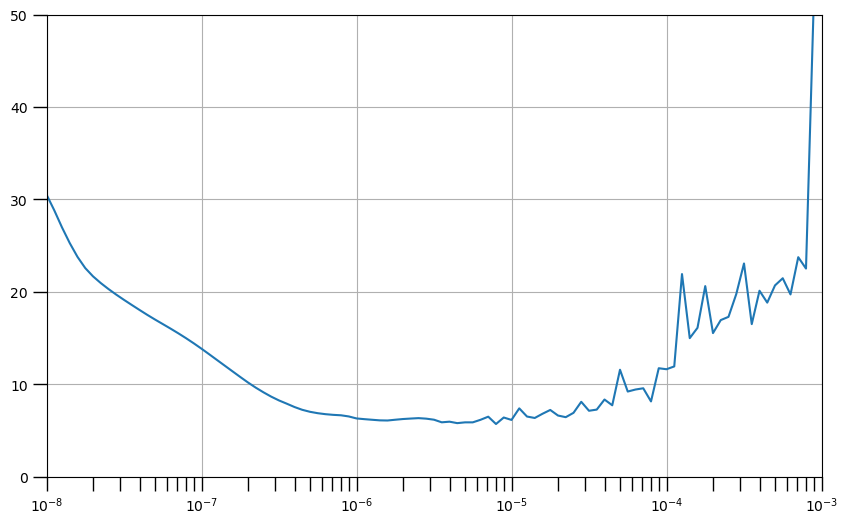

In [37]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.0001, 0.0, 20.0)

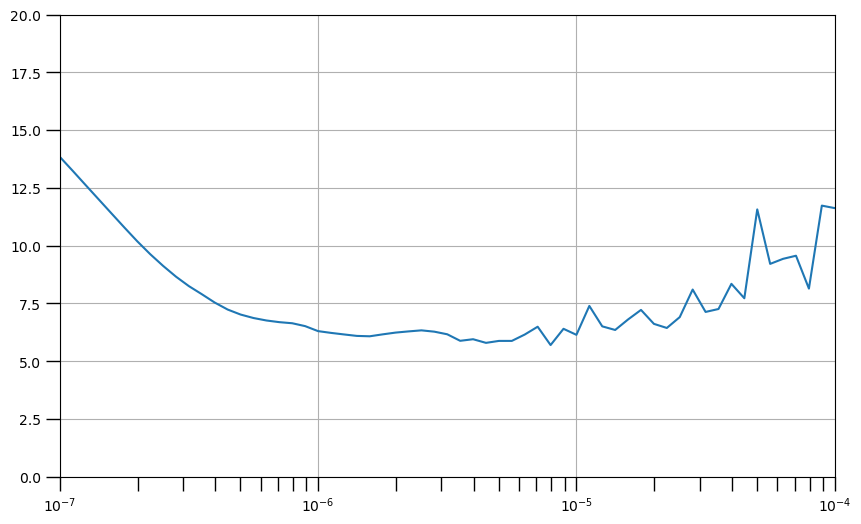

In [38]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

# Train the model

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 4e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 167.6707 - mae: 168.1697
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.2535 - mae: 15.7467
Epoch 3/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.4009 - mae: 14.8822

/home/pndx/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.1993 - mae: 12.6880
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5203 - mae: 10.0068
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3109 - mae: 7.7939
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8545 - mae: 7.3334
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6635 - mae: 7.1496
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3915 - mae: 6.8667
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3565 - mae: 6.8380
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0803 - mae: 6.5530
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1671 - mae: 6.6434
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1002 - mae: 6.5785
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1199 - mae: 6.6026
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8503 - mae: 6.3285
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5

2025-03-31 16:58:01.186272: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4518 - mae: 5.9338
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3681 - mae: 5.8486
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4647 - mae: 5.9441
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3136 - mae: 5.7940
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3462 - mae: 5.8285
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3126 - mae: 5.7942
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2799 - mae: 5.7617
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2869 - mae: 5.7696
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2502 - mae: 5.7335
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2448 - mae: 5.7276
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2214 - mae: 5.7041
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2139 - mae: 5.6959
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0

# Model prediction

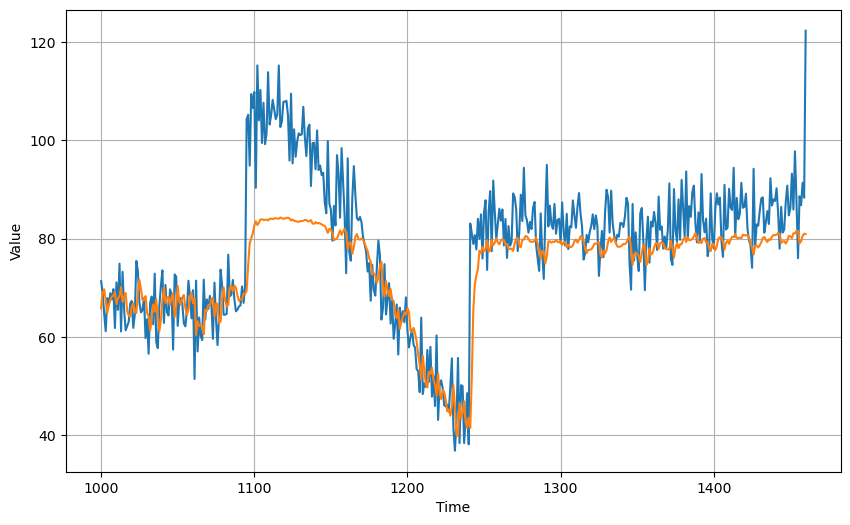

In [41]:
forecast = []

forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
    forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis], verbose = 0))

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [51]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    return forecast

/home/pndx/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


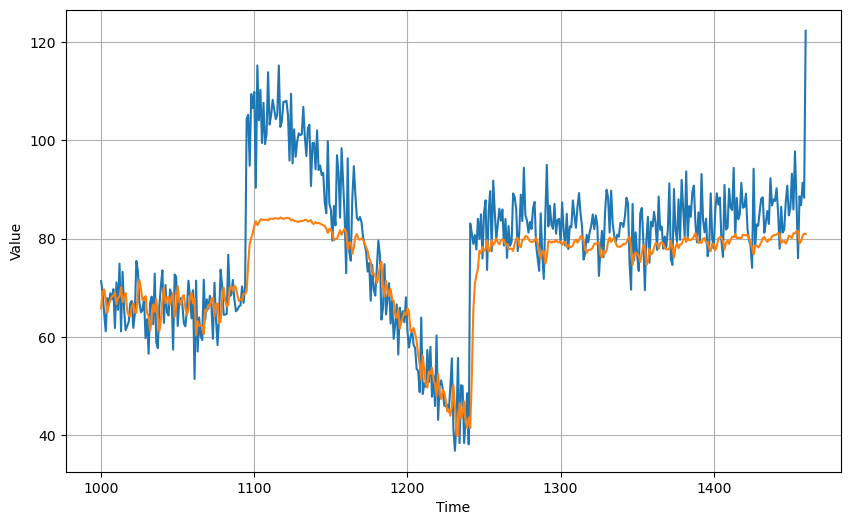

In [52]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

forecast_series = series[split_time - window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [53]:
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

94.65956
7.058967
